# Churn Prediction – Baseline (Clean, Error-Free)
**Steps covered**
1) Load dataset  
2) Explore target balance  
3) Train/test split with **stratify**  
4) Preprocess with **OneHotEncoder** (no LabelEncoder pitfalls)  
5) Train **Logistic Regression**  
6) Evaluate: classification report, ROC-AUC, confusion matrix  
7) (Optional) Save the pipeline as a `.pkl` for serving

> Make sure the CSV `telco_churn_dataset.csv` is in the same folder as this notebook.

In [1]:
# 1) Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from pathlib import Path

# Optional: for saving the trained pipeline
import joblib


In [2]:
# 2) Load dataset
# If your file is elsewhere, change the path below.
csv_path = Path(r"C:\Users\hussa\Downloads\telco_churn_dataset.csv")
# Comment out the assert if you'd like to run the notebook before adding the CSV
# assert csv_path.exists(), f"CSV not found at: {csv_path.resolve()}"

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head(10)

Shape: (500, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,nTGzL-10508,Female,0,Yes,No,10,Yes,No,Fiber optic,No,...,Yes,No,No,Yes,Month-to-month,No,Bank transfer (automatic),27.78,324.78,No
1,IKGEp-03908,Male,0,No,No,26,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,89.12,2321.10,No
2,iNJcX-57530,Female,0,No,Yes,8,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,22.87,209.92,Yes
3,vGjSn-43687,Female,0,No,Yes,47,No,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),93.73,4422.24,Yes
4,IVBce-67057,Male,0,Yes,No,55,Yes,Yes,DSL,No,...,Yes,No,No,No,Two year,Yes,Electronic check,102.31,5633.01,Yes
5,qKwmJ-07137,Male,1,No,No,19,Yes,No,DSL,No,...,No,Yes,No,No,Two year,No,Electronic check,55.94,1092.39,Yes
6,AeVYe-53980,Female,1,Yes,No,38,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),27.81,1086.43,Yes
7,RbZeJ-77694,Female,1,No,Yes,24,No,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,114.15,2781.64,No
8,gqTmp-16371,Female,1,No,No,41,No,No,Fiber optic,Yes,...,No,Yes,Yes,No,Month-to-month,No,Mailed check,53.87,2232.45,No
9,AmQsr-21542,Male,0,No,No,54,No,No,Fiber optic,Yes,...,No,Yes,No,Yes,Two year,No,Mailed check,100.09,5413.03,No


In [3]:
# 3) Quick sanity checks
print("Columns:\n", df.columns.tolist(), "\n")
print("Target distribution (Churn):\n", df['Churn'].value_counts())
print("Target distribution (%):\n", (df['Churn'].value_counts(normalize=True) * 100).round(2))


Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'] 

Target distribution (Churn):
 Churn
No     256
Yes    244
Name: count, dtype: int64
Target distribution (%):
 Churn
No     51.2
Yes    48.8
Name: proportion, dtype: float64


In [4]:
# 4) Define features and target
# - Remove unique ID
# - Convert target to 0/1
assert 'Churn' in df.columns, "Expected target column 'Churn' not found."
assert 'customerID' in df.columns, "Expected ID column 'customerID' not found."

y = (df['Churn'] == 'Yes').astype(int)
X = df.drop(columns=['Churn', 'customerID'])

# Split with stratification to avoid single-class splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train target balance:\n", y_train.value_counts(normalize=True).round(3))


Train size: (400, 19)  Test size: (100, 19)
Train target balance:
 Churn
0    0.512
1    0.488
Name: proportion, dtype: float64


In [5]:
# 5) Build preprocessing + model pipeline
# - OneHotEncode all object columns
# - Leave numeric columns as-is

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

model = LogisticRegression(max_iter=1000, solver='liblinear')

pipeline = Pipeline(steps=[
    ('prep', preprocess),
    ('model', model)
])

pipeline


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', 'passthrough',
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])

              precision    recall  f1-score   support

           0      0.442     0.451     0.447        51
           1      0.417     0.408     0.412        49

    accuracy                          0.430       100
   macro avg      0.429     0.430     0.429       100
weighted avg      0.430     0.430     0.430       100

ROC-AUC: 0.441


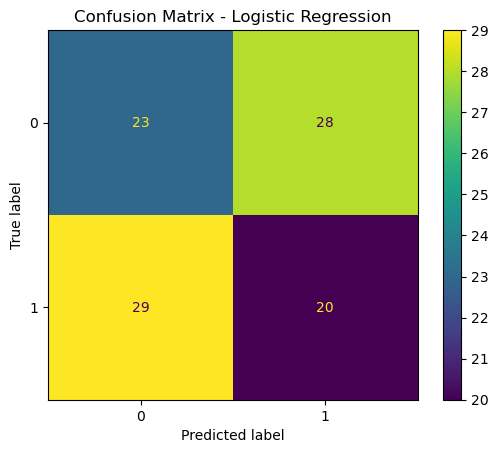

In [6]:
# 6) Train
pipeline.fit(X_train, y_train)

# 7) Evaluate
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 3))

# Confusion Matrix (matplotlib only, no seaborn)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [7]:
# 8) (Optional) Save the trained pipeline for later serving
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

out_path = models_dir / "churn_logreg_pipeline.pkl"
joblib.dump(pipeline, out_path)

out_path.resolve()


WindowsPath('C:/Users/hussa/Downloads/models/churn_logreg_pipeline.pkl')